# NO PCA and no NaN imputing

## Train-Test Split

In [1]:
from src.utils.check_mps_device import check_mps_device
import matplotlib.pyplot as plt
import plotly.express as px

from src.utils.data_loading import load_data
from src.utils.filtering import filter_data
import seaborn as sns
from src.utils.label_encoding import label_encode_column

import numpy as np

# Check if PyTorch Multi-Process Service (MPS) is available (GPU)
check_mps_device()

tensor([1.], device='mps:0')


In [2]:
selected_features = [
    "geocentric_latitude",  # Latitude of conjunction point [deg]
    "c_sigma_rdot",  # covariance; radial velocity standard deviation (sigma) of chaser [m/s]
    "c_obs_used",  # number of observations used for orbit determination (per CDM) of chaser
    "c_time_lastob_start",
    # start of the time in days of the last accepted observation used in the orbit determination of chaser
    "c_time_lastob_end",
    # end of the time interval in days of the last accepted observation used in the orbit determination of chaser
    "mahalanobis_distance",  # The distance between the chaser and target
    "miss_distance",  # relative position between chaser & target at tca [m
    "time_to_tca",  # Time interval between CDM creation and time-of-closest approach [days]
    "t_cndot_r",
    # covariance; correlation of normal (cross-track) velocity vs radial position of chaser
    "c_cr_area_over_mass",
    # solar radiation coefficient . A/m (ballistic coefficient equivalent) of chaser
    "max_risk_estimate",  # maximum collision probability obtained by scaling combined covariance
    "c_span",  # size used by the collision risk computation algorithm of chaser [m]
    "max_risk_scaling",  # scaling factor used to compute maximum collision probability
    "t_rcs_estimate",  # radar cross-sectional area [m2m2] of target
    "c_sigma_t",
    # covariance; transverse (along-track) position standard deviation (sigma) of chaser [m]
    "c_obs_available",  # number of observations available for orbit determination (per CDM),
    "risk",
]

In [3]:
# Load and data and filter it
df = load_data()
df_filtered = filter_data(df)

# Remove rows with missing values
df_filtered.dropna(axis=0, how="any", inplace=True)

# Label encode the categorical column "c_object_type"
label_encode_column(df_filtered, "c_object_type")
# Call the function to get the processed DataFrame
df_processed = df_filtered[selected_features]

# Separate features and target variable
X = df_processed.drop('risk', axis=1)
y = df_processed['risk']

Raw data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162634 entries, 0 to 162633
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 127.8+ MB
Filtered data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Columns: 103 entries, event_id to AP
dtypes: float64(98), int64(4), object(1)
memory usage: 2.4+ MB


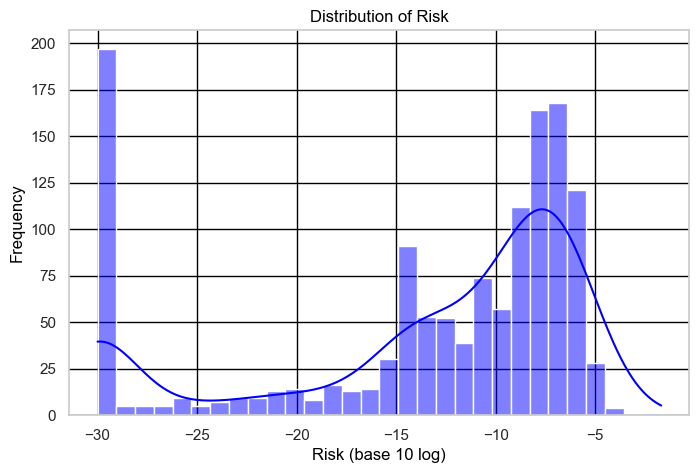

In [4]:
# Distribution of the target variable "risk" of filtered data
plt.figure(figsize=(8, 5))

# Create a white background with black grid lines
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "black"})

# Plot the histogram with a blue color
sns.histplot(y, bins=30, kde=True, color="blue")

# Set title and labels
plt.title("Distribution of Risk", color="black")
plt.xlabel("Risk (base 10 log)", color="black")
plt.ylabel("Frequency", color="black")

plt.show()


In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

y_train = np.where(y >= -6,1,0)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_train, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to balance the classes
smote = SMOTE(random_state=42, k_neighbors=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now, X_train_resampled and y_train_resampled contain the oversampled data

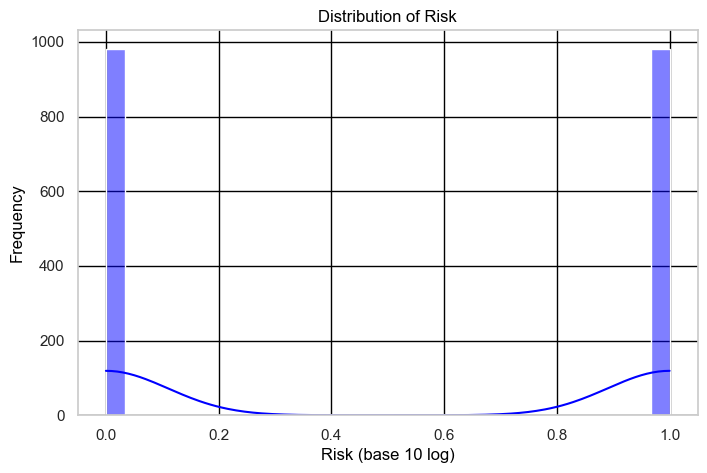

In [6]:
# Distribution of the target variable "risk" of filtered data
plt.figure(figsize=(8, 5))

# Create a white background with black grid lines
sns.set(style="whitegrid", rc={"axes.facecolor": "white", "grid.color": "black"})

# Plot the histogram with a blue color
sns.histplot(y_train_resampled, bins=30, kde=True, color="blue")

# Set title and labels
plt.title("Distribution of Risk", color="black")
plt.xlabel("Risk (base 10 log)", color="black")
plt.ylabel("Frequency", color="black")

plt.show()

## Split Data

In [7]:
from sklearn.preprocessing import StandardScaler

# # Split the data into training, testing, and validation sets
# X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

# Perform scaling after splitting the data
scaler = StandardScaler()

# Fit the scaler on the training set
X_train_scaled = scaler.fit_transform(X_train_resampled)

# Apply the same scaler to the validation and test sets

X_test_scaled = scaler.transform(X_test)

# # Display the shapes of the sets
print("Testing set shape:", X_test.shape, y_test.shape)
print("Training set shape:", X_train_scaled.shape, y_train_resampled.shape)

Testing set shape: (265, 16) (265,)
Training set shape: (1964, 16) (1964,)


## Model Selection

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Choose Models
models = {
    # 'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor()
}

# Hyperparameter Tuning
param_grid = {
    # 'Random Forest': {
    #     'n_estimators': [50, 100, 200],
    #     'max_depth': [None, 10, 20],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # }
    'Random Forest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, ],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

best_models = {}

for model_name, model in models.items():
    if model_name in param_grid:
        # Use GridSearchCV for hyperparameter tuning
        grid_search = GridSearchCV(model, param_grid[model_name], scoring='neg_mean_squared_error', cv=5)
        grid_search.fit(X_train_scaled, y_train_resampled)
        best_models[model_name] = grid_search.best_estimator_
    else:
        # For models without hyperparameters, use the default configuration
        best_models[model_name] = model.fit(X_train_scaled, y_train_resampled)

## Model Training:

In [9]:
# Train Models
for model_name, model in best_models.items():
    model.fit(X_train_scaled, y_train_resampled)

In [10]:
# Evaluate Performance
from sklearn.metrics import mean_squared_error

# Evaluate on training set
for model_name, model in best_models.items():
    y_pred_train = model.predict(X_train_scaled)
    mse_train = mean_squared_error(y_train_resampled, y_pred_train)
    print(f'{model_name} - MSE on training set: {mse_train}')



Random Forest - MSE on training set: 0.0007022403258655805
